# ML Project: Rock, Paper and Scissors

### Import data

In [7]:
import zipfile
import os 
import shutil #to delete files
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random 
import matplotlib.image as mpimg
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from pathlib import Path

In [8]:
with zipfile.ZipFile("archive.zip") as z:
    z.extractall(".") # extracts into current folder

Since it seems like there is a copy of each folder, we want to double check it and if that is the case, get rid of one of the copies.
I already manually check some images'names and they are the same, so now we check the size of the fodlers

In [9]:
def folder_size(path):
    total = 0                                            # accumulator for total bytes
    for root, subfolders , files in os.walk(path):       # walk through all subfolders and files - spits back a tuple with 3 elements: 1) root of the current folder; 2) dirs) list of the subfolders inside root; 3) files) list of files inside root
        for f in files:
            file_path = os.path.join(root, f)            # build full path to the file
            total += os.path.getsize(file_path)          # add this file's size in bytes 
    return total

paths = [
"rock", "paper", "scissors",
"rps-cv-images/rock", 
"rps-cv-images/paper",
"rps-cv-images/scissors"
]

for p in paths:
    print(p, folder_size(p))


rock 54590015
paper 54455602
scissors 54659772
rps-cv-images/rock 54590015
rps-cv-images/paper 54455602
rps-cv-images/scissors 54659772


They are exactly the same size, so we get rid of a set of them:

In [10]:
paths = ["rock", "paper", "scissors"]

for p in paths:
    print(f"Deleting: {p}")
    shutil.rmtree(p)

Deleting: rock
Deleting: paper
Deleting: scissors


### Exploratory Data Analysis

In [11]:
counts = []

for p in paths:
    path = os.path.join("rps-cv-images", p)
    for root, dirs, files in os.walk(path):
        counts.append(len(files))
        print(f"{p} set size: {len(files)}")
    

rock set size: 726
paper set size: 712
scissors set size: 750


In [12]:
data = {
"label" : paths,
"count" : counts
}

In [13]:
df = pd.DataFrame(data)

/var/folders/2_/fnz2n8m503g313y59lctx4ww0000gn/T/ipykernel_5309/3149968739.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = "label", y = "count", palette = ["skyblue", "blue", "darkblue"])


<Axes: xlabel='label', ylabel='count'>

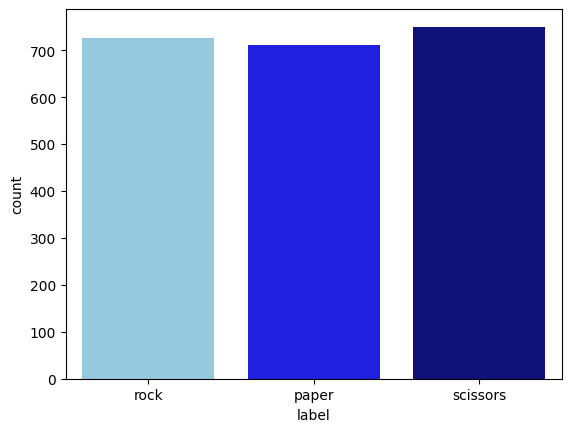

In [14]:
sns.barplot(data = df, x = "label", y = "count", palette = ["skyblue", "blue", "darkblue"])


The number of images is pretty much the same for each category, with a minimum of 712 images for paper and a maximum of 750 for scissors.
We now proceed to show some random images so that we can understand the actual quality of what we are working with

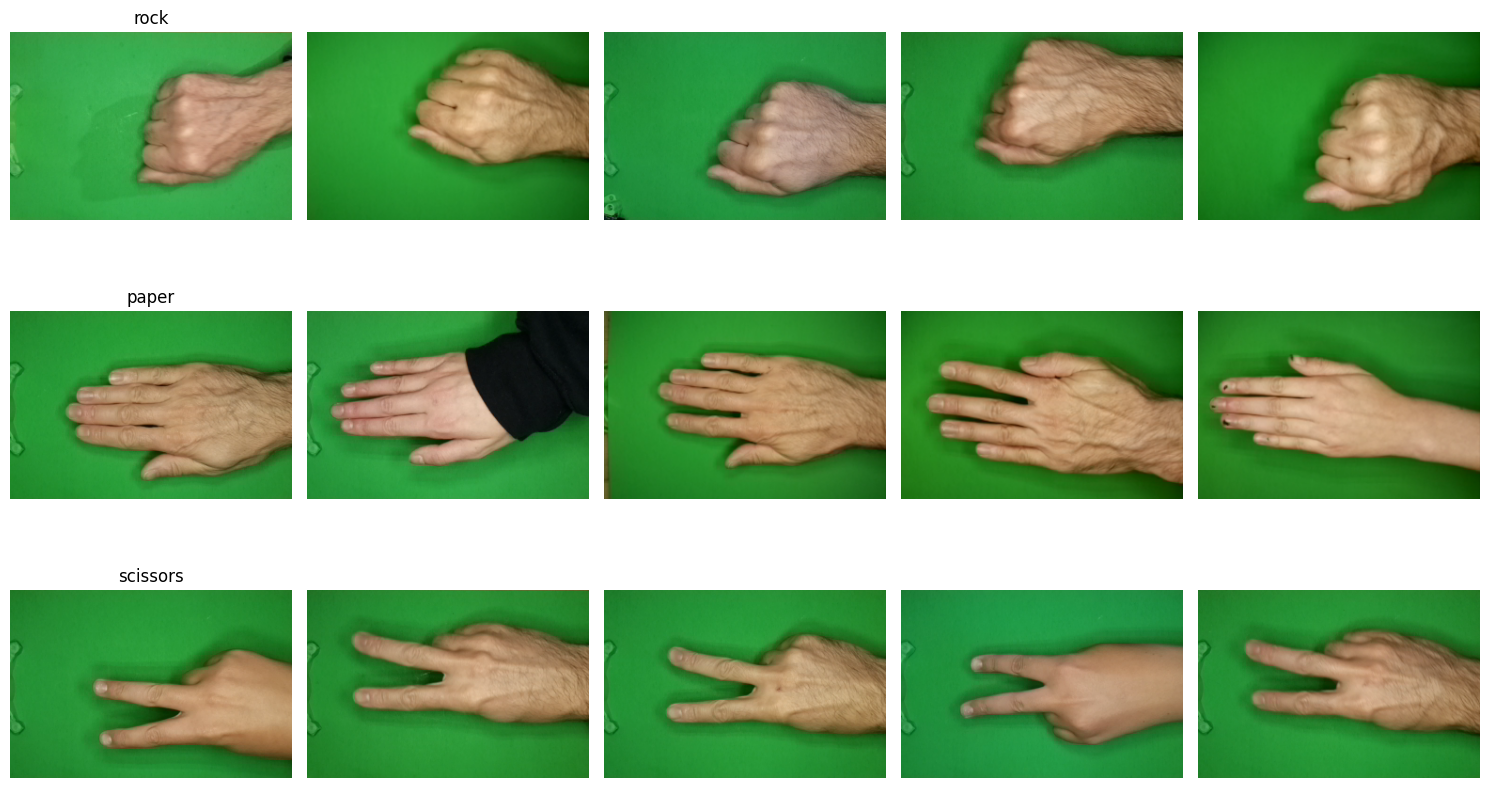

In [15]:
random.seed(19)
base_dir = "rps-cv-images"
n_per_class = 5

fig, axes = plt.subplots(len(paths), 5, figsize = (5 * 3, len(paths) * 3)) # axes is a grid of subplots

for row, label in enumerate(paths): #iterating on an object: for each step we get an index and its current value - row is the index and starts at 0
    folder = os.path.join(base_dir, label) # creates the path for one folder at a time
    files = [f for f in os.listdir(folder)] # creates a new list by iterating over the folder and collects the result in the "files" list
    chosen = random.sample(files, n_per_class)

    for col, fname in enumerate(chosen):
        img_path = os.path.join(folder, fname)
        img = mpimg.imread(img_path)  # reads the current image and load it into memory as an array-like object (tipically a numpy array)
        ax = axes[row, col] # choose the correct subplot in the axes grid of subplots
        ax.imshow(img) #shows the image
        ax.axis("off") # hides all the useless elements, the decorative ones
        if col == 0:    # set the title only on the first image of each row
            ax.set_title(label)


plt.tight_layout()
plt.show()




We can see that all the images are pretty clean and well framed, there are both left and right hands, and sometimes a hoodie or some long sleeves may appear. 
In the preprocessing we can think about flipping some random images, this because only 3/15 images in this sample are left handed.
This would encourage the model to become invariant to hand laterality rather than overfitting to a specific orientation.

# Preprocessing: 
### Image resizing and normalization
### Data augmentation techniques
### Splitting data into training and test set appropriately

### 1 - Image resizing and normalization
1.1: Image resizing: NNs expect images of same size, and our dataset contains only images that are 300 x 200, hence 60000 pixels. We will resize them as 128 x 128 to make them almost a quarter of the original size, this will help later on while training the model.

We apply further transformations on the training set, to augment our data. This is because I'd like more variance in the training data to then fit better on the validation and test sets. The variance is introduced by some random flips, random rotation and random color jittering. The random flip on 50% of the images is thought to address also the specific problem of having many more right hands than left ones in the dataset, flipping them horizontally should take care of this.

Random horizontal flips are justified because the gesture can be performed with either hand and left hands are underrepresented in the dataset; flipping helps the model become invariant to hand laterality. Small random rotations are also reasonable, since people will not always hold their hand perfectly aligned, and this makes the model more robust to realistic variations in pose. Finally, color jitter encourages the model to rely more on shape than on exact pixel values, which is useful for generalization to new and unseen images (other than the Kaggle dataset) where lighting conditions and backgrounds differ from the training set. The strength of these augmentations is kept moderate to avoid generating unrealistic images that could harm training.

In [16]:
img_size = (128, 128)
train_transform = transforms.Compose([        # here we are creating a single pipeline object, later on when we will call transform on an image it will apply each transformation in order
    transforms.Resize(img_size), 
    transforms.RandomHorizontalFlip(p = 0.5), # p is the percentage, so we flip 50% of the time
    transforms.RandomRotation(degrees= 15),   # rotate each image by a small angle [-15°, 15°]
    transforms.ColorJitter(                   # random color variation
        brightness = 0.2,                     # scales images brightness by a factor in [0.8, 1.2]
        saturation = 0.2,
        contrast = 0.2,
        hue = 0.1                             # tonalità
    ),
    transforms.ToTensor(),              # converts the image into a PyTorch tensor and scales pixel values from [0,255] to [0,1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])    # for each RGB channel applies (x - 0.5)/0.5 - this turns [0,1] into [-1,1] which is conveniente for training
])


val_transform = transforms.Compose([        
    transforms.Resize(img_size), 
    transforms.ToTensor(),              
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])




In [17]:




"""train_dataset = datasets.ImageFolder(   # scans subfolders of base_dir: each one of the subfolders becomes a class label
    root= base_dir,               # for each image then pytorch will apply the transform pipeline and returns an object whose key internal  
    transform= train_transform)         # representation is essentially a list where each element pairs an image file path with its class index

val_dataset = datasets.ImageFolder(
    root= base_dir,
    transform= val_transform
)


print(train_dataset.samples)
print(train_dataset.classes)
print(train_dataset.class_to_idx)
print(train_dataset.transform)

# when you index PyTorch uses the i-th tuple in the internal list to get (path, label), then loads the image from path, applies transform, and 
# returns (image, label). NB: image is now a tensor (since our transformation returns a tensor)
print(train_dataset[723])"""

'train_dataset = datasets.ImageFolder(   # scans subfolders of base_dir: each one of the subfolders becomes a class label\n    root= base_dir,               # for each image then pytorch will apply the transform pipeline and returns an object whose key internal  \n    transform= train_transform)         # representation is essentially a list where each element pairs an image file path with its class index\n\nval_dataset = datasets.ImageFolder(\n    root= base_dir,\n    transform= val_transform\n)\n\n\nprint(train_dataset.samples)\nprint(train_dataset.classes)\nprint(train_dataset.class_to_idx)\nprint(train_dataset.transform)\n\n# when you index PyTorch uses the i-th tuple in the internal list to get (path, label), then loads the image from path, applies transform, and \n# returns (image, label). NB: image is now a tensor (since our transformation returns a tensor)\nprint(train_dataset[723])'

Now we configure our split into train, val and test sets, and then transform the data accordingly to their purpose

In [18]:

src_root = Path("rps-cv-images")   # current data folder
dst_root = Path("rps-split")       # organized folder

classes = paths


train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15



# helper functions 

def list_images(folder: Path):
    """Return a sorted list of PNG files in the folder - this is used to get a list of file paths for each 
    class, then shuffle the list and split into train, val and test """
    files = []
    for p in folder.iterdir():
        files.append(p)
    return sorted(files)

def ensure_dir(path: Path):
    """Create directory if it doesn't exist"""
    path.mkdir(parents=True, exist_ok=True)

def split_counts(n, train_ratio, val_ratio):
    """Given n items, return (n_train, n_val, n_test) that sum to n"""
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    n_test  = n - n_train - n_val  # remainder
    return n_train, n_val, n_test

def transfer_file(src: Path, dst: Path, copy=True):
    """Copy or move one file from src to dst"""
    ensure_dir(dst.parent)  # make sure destination folder exists
    if copy:
        shutil.copy2(src, dst)
    else:
        shutil.move(str(src), str(dst))


# main split logic 



# create destination folders for each split and class
for split_name in ["train", "val", "test"]:
    for cls in classes:
        ensure_dir(dst_root / split_name / cls)

stats = {}

for cls in classes:
    src_dir = src_root / cls

    # List all png images in this class
    images = list_images(src_dir)

    # Shuffle them deterministically (in place)
    random.shuffle(images)

    # Compute how many go into each split
    n = len(images)
    n_train, n_val, n_test = split_counts(n, train_ratio, val_ratio)

    train_files = images[:n_train]
    val_files   = images[n_train:n_train + n_val]
    test_files  = images[n_train + n_val:]

    assert len(train_files) + len(val_files) + len(test_files) == n # if condition is false it returns an error

    # Transfer files to destination structure
    for src_path in train_files:
        dst_path = dst_root / "train" / cls / src_path.name
        transfer_file(src_path, dst_path, copy= True)

    for src_path in val_files:
        dst_path = dst_root / "val" / cls / src_path.name
        transfer_file(src_path, dst_path, copy=True)

    for src_path in test_files:
        dst_path = dst_root / "test" / cls / src_path.name
        transfer_file(src_path, dst_path, copy=True)

    stats[cls] = {
        "total": n,
        "train": len(train_files),
        "val": len(val_files),
        "test": len(test_files)
    }


In [19]:
train_ds = datasets.ImageFolder("rps-split/train", transform=train_transform)
val_ds   = datasets.ImageFolder("rps-split/val",   transform=val_transform)
test_ds  = datasets.ImageFolder("rps-split/test",  transform=val_transform)


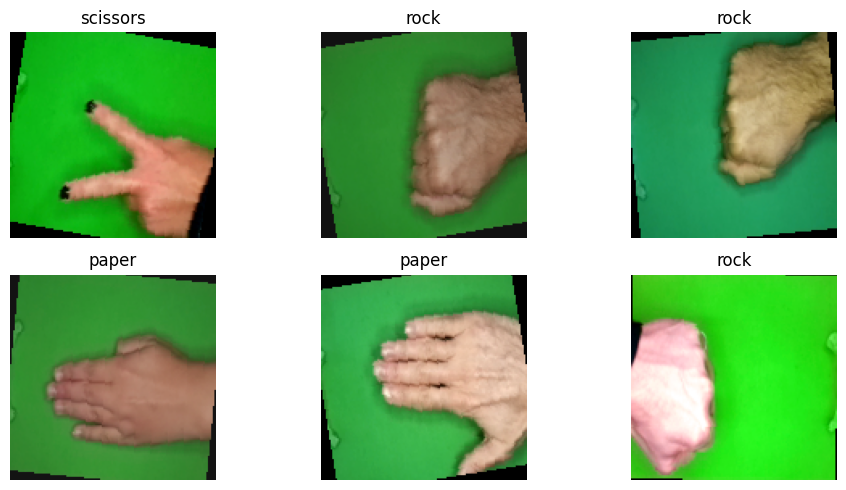

In [20]:

# pick 6 random indices from the train dataset
idxs = random.sample(range(len(train_ds)), k=6)

plt.figure(figsize=(10, 5))

for i, idx in enumerate(idxs):
    img, label = train_ds[idx]           # img is a tensor, normalized
    # undo normalization just for display
    img_disp = img * 0.5 + 0.5           # [-1,1] -> [0,1]
    img_disp = img_disp.permute(1, 2, 0) # CHW -> HWC

    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(img_disp)
    ax.axis("off")
    ax.set_title(train_ds.classes[label])

plt.tight_layout()
plt.show()